# Corona Virus Exploratory Analysis and Modeling 

![](https://img.webmd.com/dtmcms/live/webmd/consumer_assets/site_images/article_thumbnails/news/2020/01_2020/coronavirus_1/1800x1200_coronavirus_1.jpg)

# 1. Import Library

In [1]:
# System
import sys
import os
import operator
import argparse
import itertools

# Time
import time
import datetime
from time import gmtime, strftime
from pytz import timezone

# Numerical Data
import random
import numpy as np 
import pandas as pd

# Tools
import shutil
from glob import glob
from tqdm import tqdm
import gc

# NLP
import re

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

# Evaluation Metrics
from sklearn import metrics 
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


# Deep Learning - Keras -  Preprocessing
from keras.preprocessing.image import ImageDataGenerator

# Deep Learning - Keras - Model
import keras
from keras import models
from keras.models import Model
from keras.models import load_model
from keras.models import Sequential

# Deep Learning - Keras - Layers
from keras.layers import Convolution1D, concatenate, SpatialDropout1D, GlobalMaxPool1D, GlobalAvgPool1D, Embedding, \
    Conv2D, SeparableConv1D, Add, BatchNormalization, Activation, GlobalAveragePooling2D, LeakyReLU, Flatten
from keras.layers import Dense, Input, Dropout, MaxPool2D, MaxPooling2D, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    Lambda, Multiply, LSTM, Bidirectional, PReLU, MaxPooling1D
from keras.layers.pooling import _GlobalPooling1D

from keras.regularizers import l2

# Deep Learning - Keras - Pretrained Models
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

from keras.applications.nasnet import preprocess_input

# Deep Learning - Keras - Model Parameters and Evaluation Metrics
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

# Deep Learning - Keras - Visualisation
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
# from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

# Deep Learning - TensorFlow
import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix
from wordcloud import WordCloud

# Image
import cv2
from PIL import Image
from IPython.display import display
from IPython.core.display import HTML

# np.random.seed(42)

%matplotlib inline

# Input data
print(os.listdir("../input/"))

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['corona-virus-time-series-dataset']


### Time of last edit

In [2]:
fmt = "%a, %d %B %Y %H:%M:%S %Z%z"
pacific = timezone('US/Pacific')
loc_dt = datetime.datetime.now(pacific)
print("Pacific Time" + " : " + loc_dt.strftime(fmt))

Pacific Time : Wed, 11 March 2020 15:04:22 PDT-0700


# 2. Read Data

In [3]:
input_dir = "../input/corona-virus-time-series-dataset/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"

In [4]:
time_series_covid_19_confirmed = pd.read_csv(input_dir + "time_series_19-covid-Confirmed.csv")
time_series_covid_19_recovered = pd.read_csv(input_dir + "time_series_19-covid-Recovered.csv")
time_series_covid_19_deaths = pd.read_csv(input_dir + "time_series_19-covid-Deaths.csv")

Lets see some data

In [5]:
columns = time_series_covid_19_confirmed.columns.tolist()
location_columns = ['Province/State', 'Country/Region', 'Lat', 'Long']
location_long_lat_columns = ['Lat', 'Long']
location_name_cols = ['Country/Region', 'Province/State']

data_cols = [c for c in columns if c not in location_columns]

last_day = columns[-1]

new_cols = location_name_cols + [last_day]

In [6]:
# time_series_covid_19_confirmed.info()
time_series_covid_19_confirmed.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_confirmed.fillna("NA", inplace=True)
time_series_covid_19_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
80,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,4,4
252,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
83,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1,1,3,5,12,12,17,17,19,20
118,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1
133,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,0,0,0,1,1,1,2,8,12,12


In [7]:
time_series_covid_19_confirmed_country = time_series_covid_19_confirmed.drop(columns=location_long_lat_columns)
time_series_covid_19_confirmed_country = time_series_covid_19_confirmed_country.groupby(['Country/Region']).sum()
time_series_covid_19_confirmed_country.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,4,4
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Algeria,0,0,0,0,0,0,0,0,0,0,...,1,1,3,5,12,12,17,17,19,20
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1
Argentina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,2,8,12,12


In [8]:
# time_series_covid_19_recovered.info()
time_series_covid_19_recovered.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_recovered.fillna("NA", inplace=True)
# time_series_covid_19_recovered.head()

In [9]:
time_series_covid_19_recovered_country = time_series_covid_19_recovered.drop(columns=location_long_lat_columns)
time_series_covid_19_recovered_country = time_series_covid_19_recovered_country.groupby(['Country/Region']).sum()
time_series_covid_19_recovered_country.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Argentina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# time_series_covid_19_deaths.info()
time_series_covid_19_deaths.sort_values(["Country/Region", "Province/State"], inplace=True)
# time_series_covid_19_deaths.fillna("NA", inplace=True)
time_series_covid_19_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
80,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
252,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [11]:
time_series_covid_19_deaths_country = time_series_covid_19_deaths.drop(columns=location_long_lat_columns)
time_series_covid_19_deaths_country = time_series_covid_19_deaths_country.groupby(['Country/Region']).sum()
time_series_covid_19_deaths_country.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Albania,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Algeria,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andorra,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Argentina,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


In [12]:
time_series_covid_19_confirmed[data_cols].fillna(0, inplace=True)
time_series_covid_19_recovered[data_cols].fillna(0, inplace=True)
time_series_covid_19_deaths[data_cols].fillna(0, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


In [13]:
last_confirmed_df = time_series_covid_19_confirmed[location_name_cols + [last_day]]
last_confirmed_df.rename(columns = {last_day: "Confirm"}, inplace=True)

last_recovered_df = time_series_covid_19_recovered[location_name_cols + [last_day]]
last_recovered_df.rename(columns = {last_day: "Recover"}, inplace=True)

last_death_df = time_series_covid_19_deaths[location_name_cols + [last_day]]
last_death_df.rename(columns = {last_day: "Death"}, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [14]:
result1 = last_confirmed_df.merge(last_recovered_df, on = ["Country/Region", "Province/State"])
result = result1.merge(last_death_df, on = ["Country/Region", "Province/State"])

In [15]:
country_list = result['Country/Region'].unique().tolist()
state_list = result['Province/State'].unique().tolist()

In [16]:
def fatality_rate_func(country="Total", state=""):
    if not state == "":
        return (time_series_covid_19_deaths[time_series_covid_19_deaths["Province/State"]==state][data_cols].sum()/time_series_covid_19_confirmed[time_series_covid_19_confirmed["Province/State"]==state][data_cols].sum())*100
    elif country == "Total":
        return (time_series_covid_19_deaths[data_cols].sum()/time_series_covid_19_confirmed[data_cols].sum())*100
    else:
        return (time_series_covid_19_deaths[time_series_covid_19_deaths["Country/Region"]==country][data_cols].sum()/time_series_covid_19_confirmed[time_series_covid_19_confirmed["Country/Region"]==country][data_cols].sum())*100

In [17]:
result_country = result.groupby(['Country/Region']).sum()
result_country["Fatality Rate"] = ((result_country["Death"]/result_country["Confirm"])*100).round(0).astype(int)
result_country["Recovery Rate"] = ((result_country["Recover"]/result_country["Confirm"])*100).round(0).astype(int)

In [18]:
total_confirm = result_country[['Confirm']].sum().values[0]
total_recover = result_country[['Recover']].sum().values[0]
total_death = result_country[['Death']].sum().values[0]

total_active = total_confirm - (total_recover + total_death)

global_persistence_rate = (total_active / total_confirm) * 100
global_recovery_rate = (total_recover / total_confirm) * 100
global_fatality_rate = (total_death / total_confirm) * 100

In [19]:
m_sum = {"Total Confirmed": total_confirm, 
         "Total Active"   : total_recover,
         "Total Recovered": total_death, 
         "Total Deaths"   : total_active}

pd.DataFrame(m_sum.items(), columns=['Global', 'Value'])

,Global,Value
0,Total Confirmed,113583
1,Total Active,62512
2,Total Recovered,3996
3,Total Deaths,47075


In [20]:
m_rate = {"Persistence Rate": global_persistence_rate,
          "Recovery Rate"   : global_recovery_rate,
          "Fatality Rate"   : global_fatality_rate
         }

pd.DataFrame(m_rate.items(), columns=['Global', 'Value(%)'])

,Global,Value(%)
0,Persistence Rate,41.445463
1,Recovery Rate,55.036405
2,Fatality Rate,3.518132


In [21]:
from bokeh.plotting import figure, output_file, show

# output_file('vbar.html')

p = figure(plot_width=400, plot_height=400)
p.vbar(x=[1, 2, 3], width=0.5, bottom=0,
       top=[1.2, 2.5, 3.7], color="firebrick")

show(p)

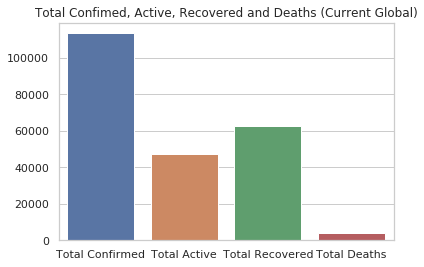

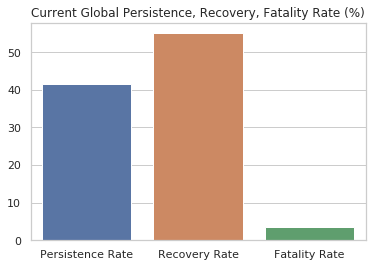

In [22]:
sns.set(style="whitegrid")

data = [total_confirm, total_active, total_recover, total_death]
labels = ["Total Confirmed", "Total Active", "Total Recovered", "Total Deaths"]

title = "Total Confimed, Active, Recovered and Deaths (Current Global)"


sns.barplot(x=labels, y=data)
plt.title(title)
plt.show()    


data = [global_persistence_rate, global_recovery_rate, global_fatality_rate]
labels = ["Persistence Rate", "Recovery Rate", "Fatality Rate"]

title = "Current Global Persistence, Recovery, Fatality Rate (%)"

sns.barplot(x=labels, y=data)
plt.title(title)
plt.show()    


In [23]:
max_row = 13
print("Countries with Most Confimed")
display(HTML(result_country.sort_values(by="Confirm", ascending=False)[:max_row].to_html()))

Countries with Most Confimed


,Confirm,Recover,Death,Fatality Rate,Recovery Rate
Country/Region,,,,,
Mainland China,80735,58735,3120,4,73
Italy,9172,724,463,5,8
South Korea,7478,118,53,1,2
Iran,7161,2394,237,3,33
France,1209,12,19,2,1
Germany,1176,18,2,0,2
Spain,1073,32,28,3,3
Others,696,40,6,1,6
US,605,8,22,4,1


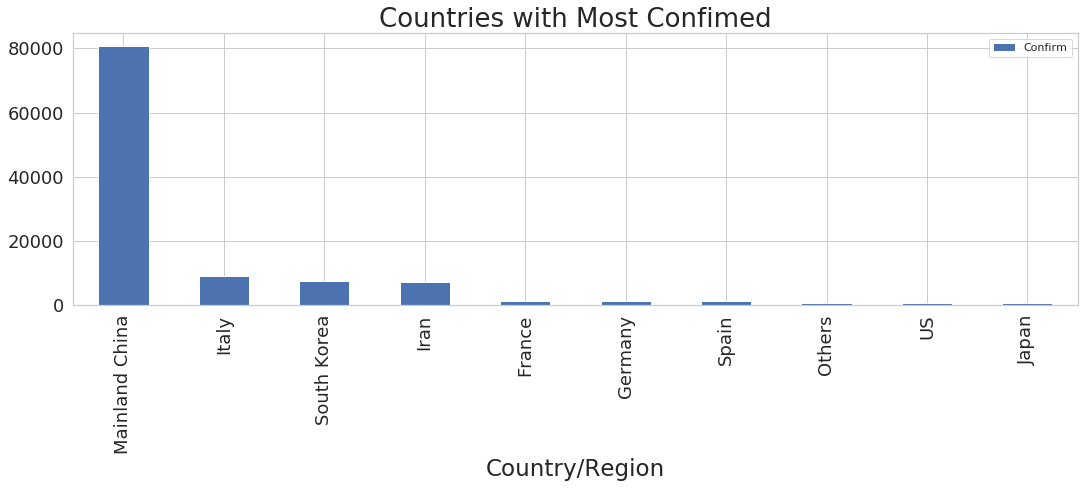

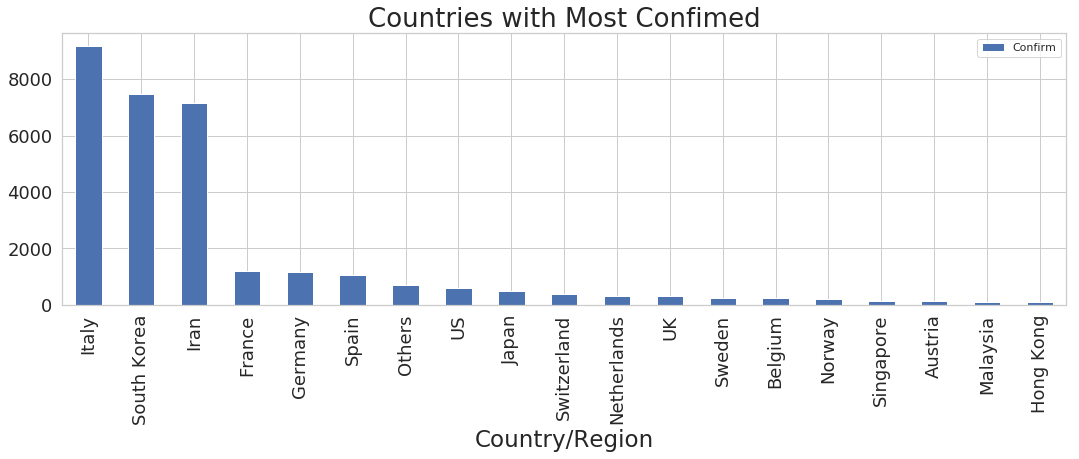

In [24]:
ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


title = "Countries with Most Confimed"

ymin = -1
ymax = 6

result_country[['Confirm']].sort_values(by="Confirm", ascending=False)[:10].plot(kind="bar")
plt.title(title)
plt.xticks(rotation=90)
plt.show()    

result_country[['Confirm']].sort_values(by="Confirm", ascending=False)[1:20].plot(kind="bar")
plt.title(title)
plt.xticks(rotation=90)
plt.show()    


In [25]:
max_row = 10
print("Countries with Most Recovered")
display(HTML(result_country.sort_values(by="Recover", ascending=False)[:max_row].to_html()))

Countries with Most Recovered


,Confirm,Recover,Death,Fatality Rate,Recovery Rate
Country/Region,,,,,
Mainland China,80735,58735,3120,4,73
Iran,7161,2394,237,3,33
Italy,9172,724,463,5,8
South Korea,7478,118,53,1,2
Singapore,150,78,0,0,52
Japan,511,76,17,3,15
Hong Kong,115,59,3,3,51
Others,696,40,6,1,6
Spain,1073,32,28,3,3


In [26]:
max_row = 17
print("Countries with Most Death")
display(HTML(result_country.sort_values(by="Death", ascending=False)[:max_row].to_html()))

Countries with Most Death


,Confirm,Recover,Death,Fatality Rate,Recovery Rate
Country/Region,,,,,
Mainland China,80735,58735,3120,4,73
Italy,9172,724,463,5,8
Iran,7161,2394,237,3,33
South Korea,7478,118,53,1,2
Spain,1073,32,28,3,3
US,605,8,22,4,1
France,1209,12,19,2,1
Japan,511,76,17,3,15
Others,696,40,6,1,6


In [27]:
max_row = 18
print("Countries with Highest Fatality Rate")
display(HTML(result_country.sort_values(by=["Fatality Rate", "Confirm"], ascending=False)[:max_row].to_html()))

Countries with Highest Fatality Rate


,Confirm,Recover,Death,Fatality Rate,Recovery Rate
Country/Region,,,,,
Iraq,60,9,6,10,15
Argentina,12,0,1,8,0
Italy,9172,724,463,5,8
Philippines,20,1,1,5,5
Mainland China,80735,58735,3120,4,73
US,605,8,22,4,1
Australia,91,21,4,4,23
Iran,7161,2394,237,3,33
Spain,1073,32,28,3,3


In [28]:
thres = 25
max_row = 25
print("Countries with Lowest Fatality Rate (Confirm > " + str(thres) + ")")
display(HTML(result_country[result_country["Confirm"]>thres].sort_values(by=["Fatality Rate"], ascending=True)[:max_row].to_html()))

Countries with Lowest Fatality Rate (Confirm > 25)


,Confirm,Recover,Death,Fatality Rate,Recovery Rate
Country/Region,,,,,
Vietnam,30,16,0,0,53
United Arab Emirates,45,7,0,0,16
Sweden,248,1,0,0,0
Israel,39,2,0,0,5
Malaysia,117,24,0,0,21
Singapore,150,78,0,0,52
India,43,3,0,0,7
Iceland,58,0,0,0,0
Greece,73,0,0,0,0


In [29]:
max_row = 20
print("Countries with Highest Recovery Rate")
display(HTML(result_country.sort_values(by=["Recovery Rate", "Confirm"], ascending=False)[:max_row].to_html()))

Countries with Highest Recovery Rate


,Confirm,Recover,Death,Fatality Rate,Recovery Rate
Country/Region,,,,,
Macau,10,10,0,0,100
Nepal,1,1,0,0,100
Sri Lanka,1,1,0,0,100
Mainland China,80735,58735,3120,4,73
Thailand,50,31,1,2,62
Vietnam,30,16,0,0,53
Singapore,150,78,0,0,52
Hong Kong,115,59,3,3,51
Cambodia,2,1,0,0,50


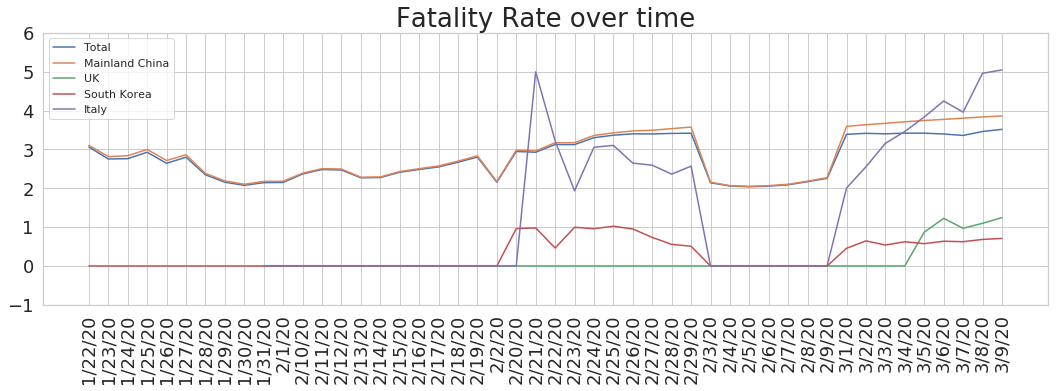

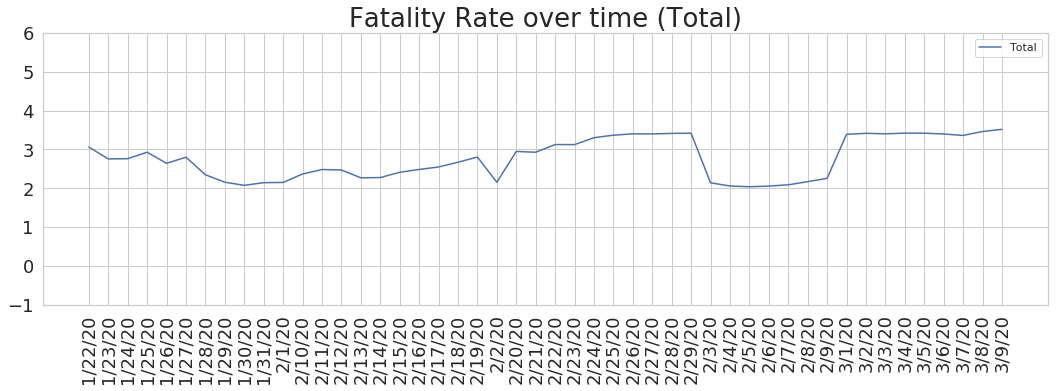

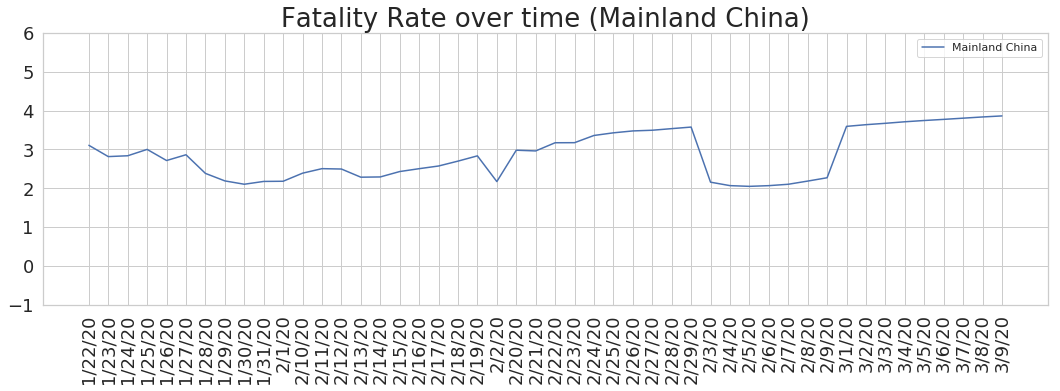

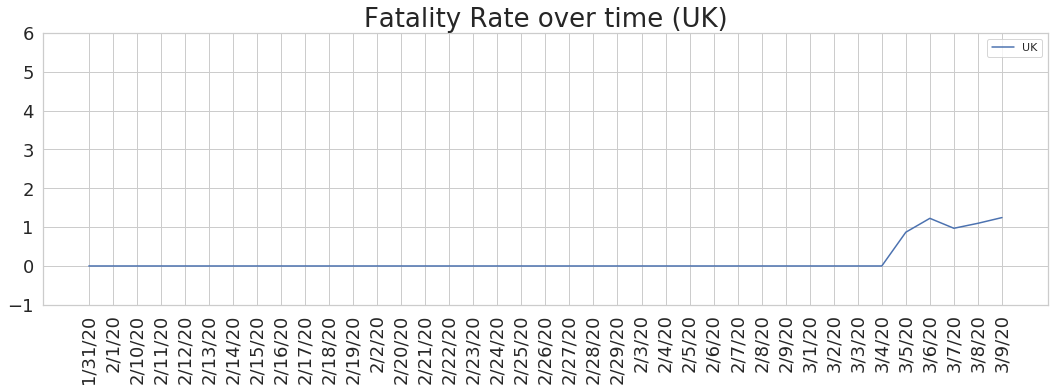

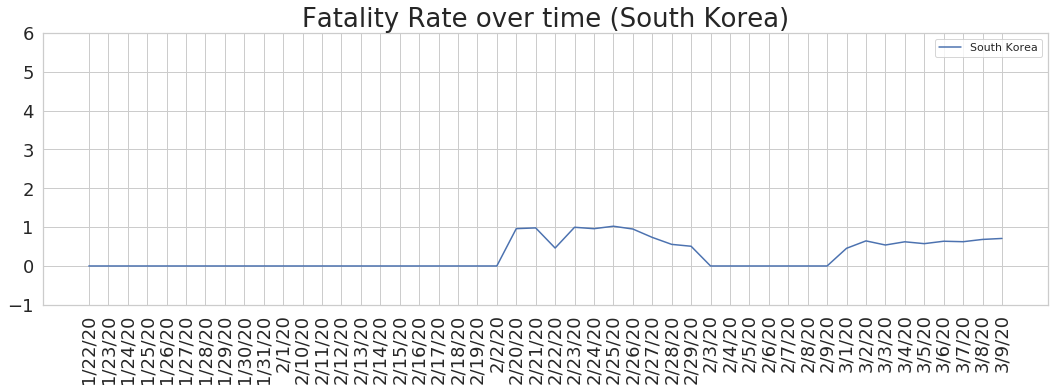

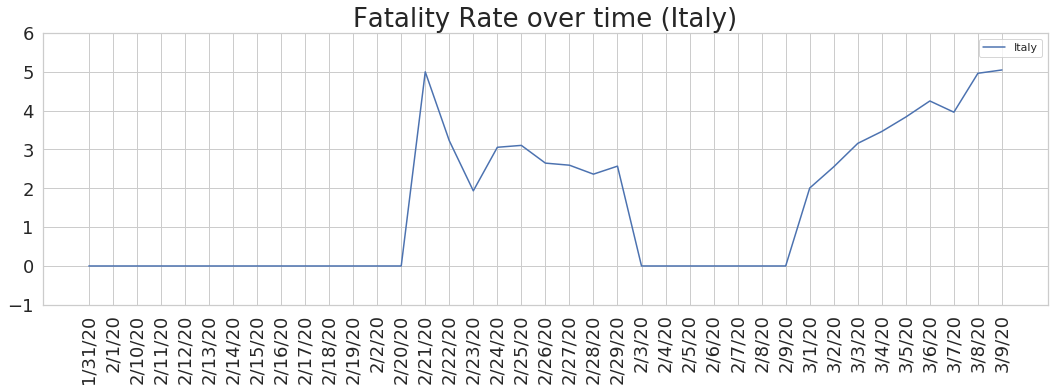

In [30]:
ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

countries = ["Total", 'Mainland China', 'UK', 'South Korea', 'Italy']
# countries = result_cont.index.get_level_values('Country/Region').tolist()
# title = "Fatality Rate over time"

title = "Fatality Rate over time"

ymin = -1
ymax = 6

for country in countries:  
    fatality_rate = fatality_rate_func(country=country, state="")
    sns.lineplot(x=data_cols, y=fatality_rate, label=country)
plt.title(title)
plt.xticks(rotation=90)
plt.ylim(ymin, ymax)
plt.show()

for country in countries:  
    title = "Fatality Rate over time (" + country + ")"
    fatality_rate = fatality_rate_func(country=country, state="")
    sns.lineplot(x=data_cols, y=fatality_rate, label=country)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylim(ymin, ymax)
    plt.show()

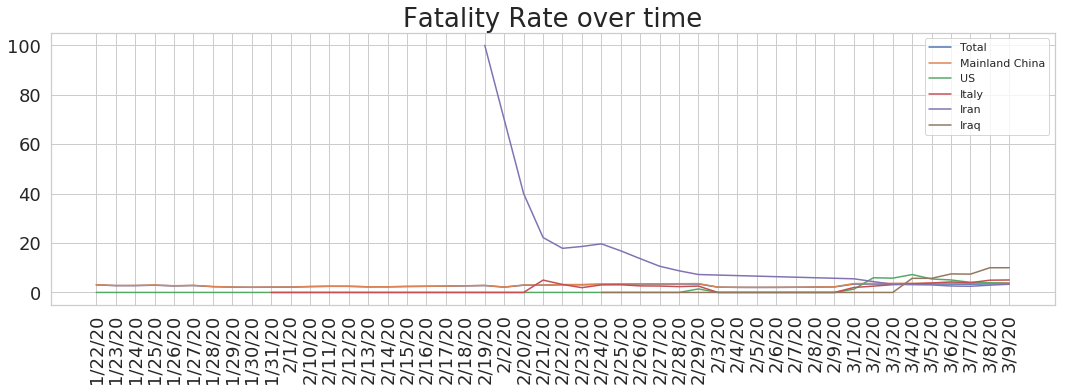

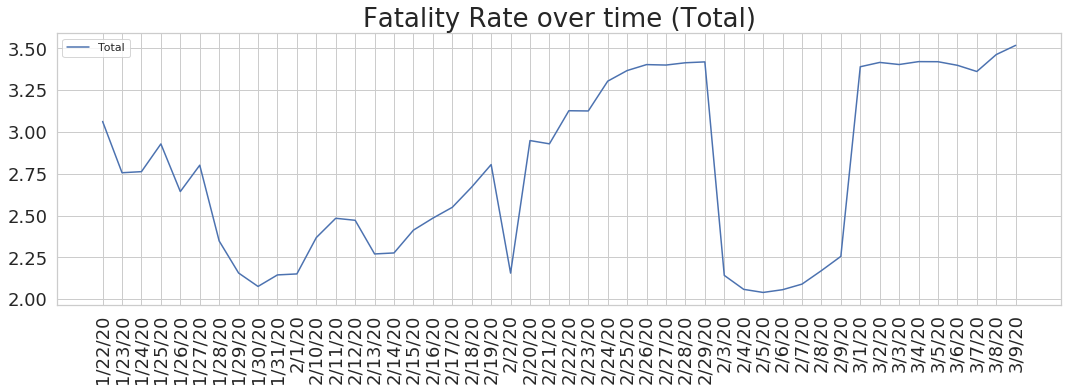

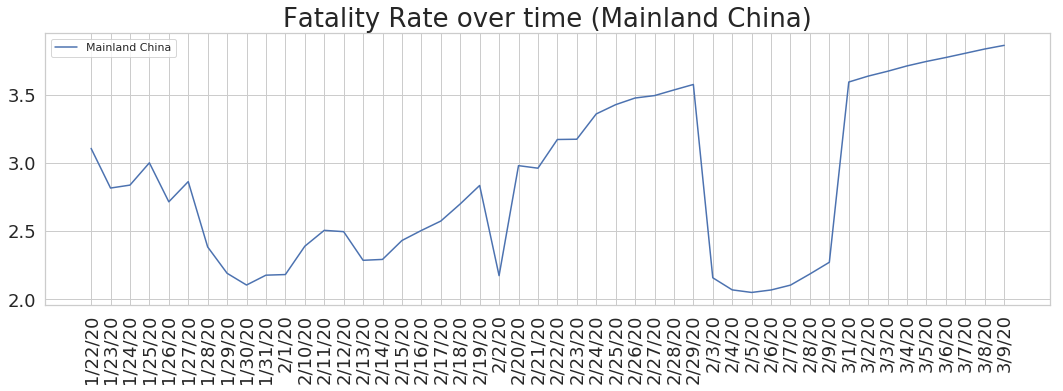

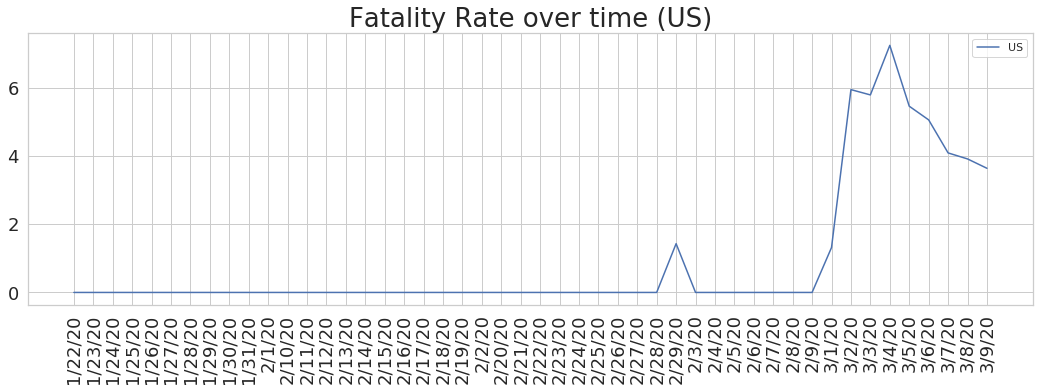

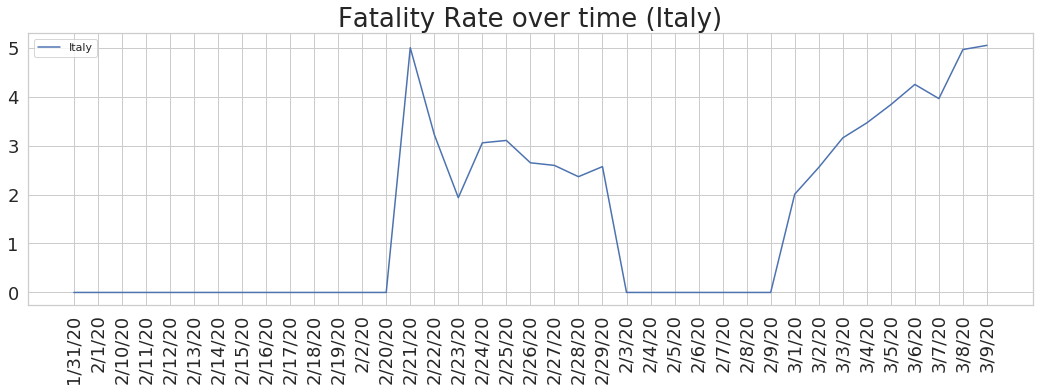

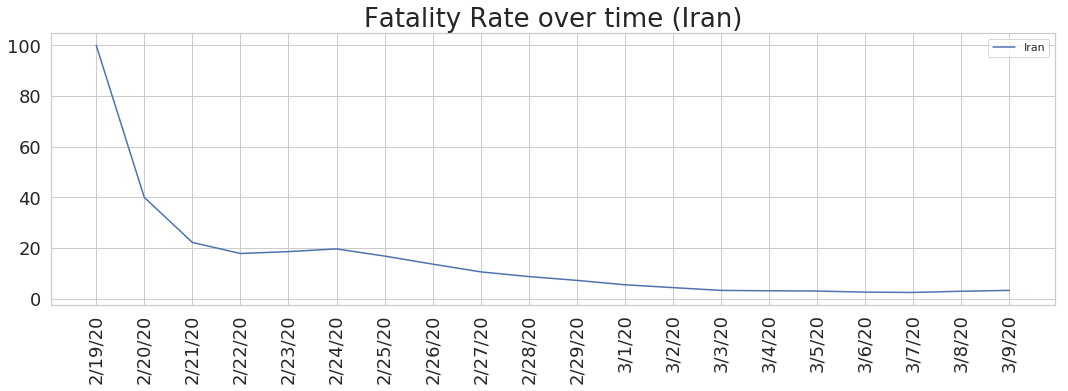

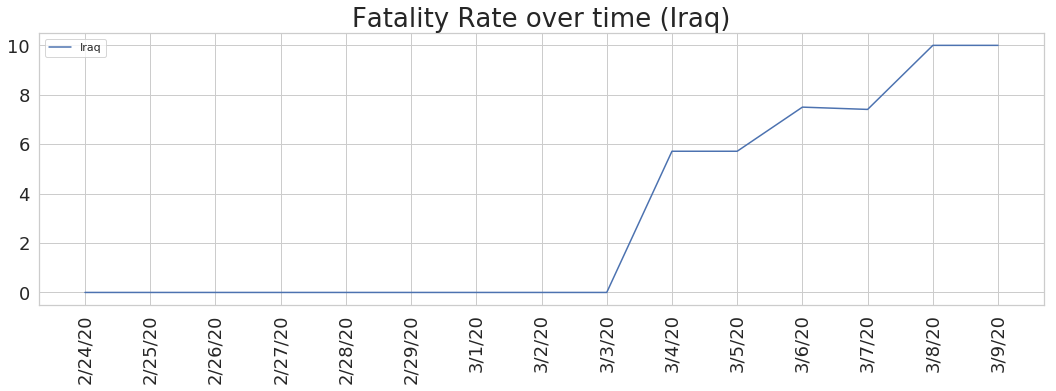

In [31]:
ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

countries = ["Total", 'Mainland China', 'US', 'Italy', "Iran", "Iraq"]
# countries = result_cont.index.get_level_values('Country/Region').tolist()
# title = "Fatality Rate over time"

title = "Fatality Rate over time"

ymin = -1
ymax = 6

for country in countries:  
    fatality_rate = fatality_rate_func(country=country, state="")
    sns.lineplot(x=data_cols, y=fatality_rate, label=country)
plt.title(title)
plt.xticks(rotation=90)
# plt.ylim(ymin, ymax)
plt.show()


# deaths = time_series_covid_19_deaths_country.reset_index()
for country in countries:  
    title = "Fatality Rate over time (" + country + ")"
    fatality_rate = fatality_rate_func(country=country, state="")
    sns.lineplot(x=data_cols, y=fatality_rate, label=country)
#     if not country=="Total":
#         death_count = deaths[deaths["Country/Region"]==country][last_day].values
#         plt.title(title + "(Total Deaths: " + str(deaths_count) + ")")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Visualization

In [32]:
total_confirm = time_series_covid_19_confirmed[last_day].sum()
total_recovered = time_series_covid_19_recovered[last_day].sum()
total_death = time_series_covid_19_deaths[last_day].sum()

df_total = pd.DataFrame({"Confirm": [total_confirm],
                         "Recover": [total_recovered],
                         "Death": [total_death]})
df_total.head()

,Confirm,Recover,Death
0,113583,62512,3996


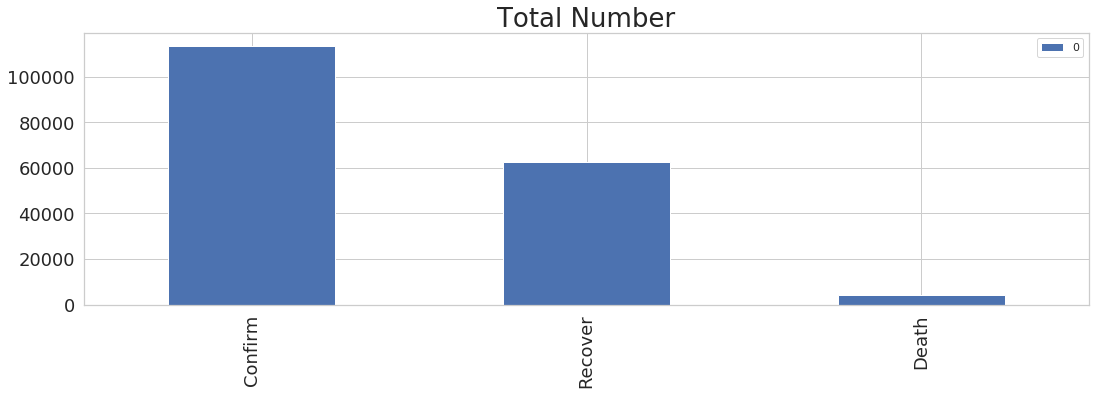

In [33]:
ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

title = "Total Number"

df_total.T.plot(kind="bar")
plt.title(title)
plt.show()

In [34]:
count_days_vis = {len(data_cols): "line", 30: "line", 15: "line", 7: "line"}

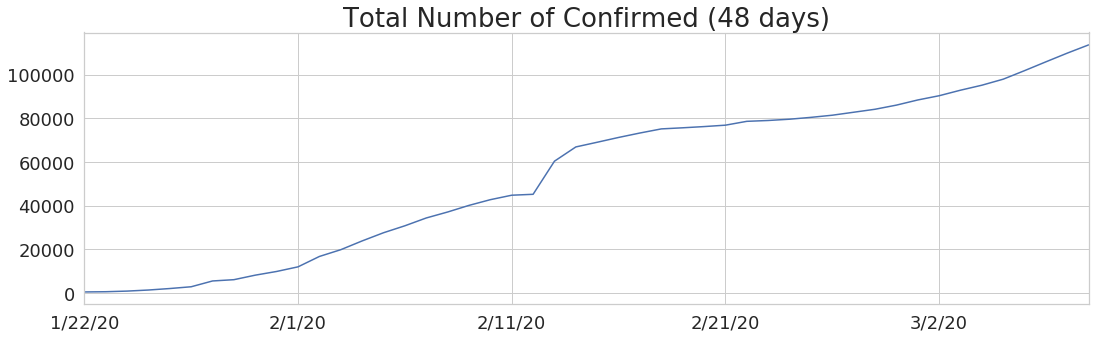

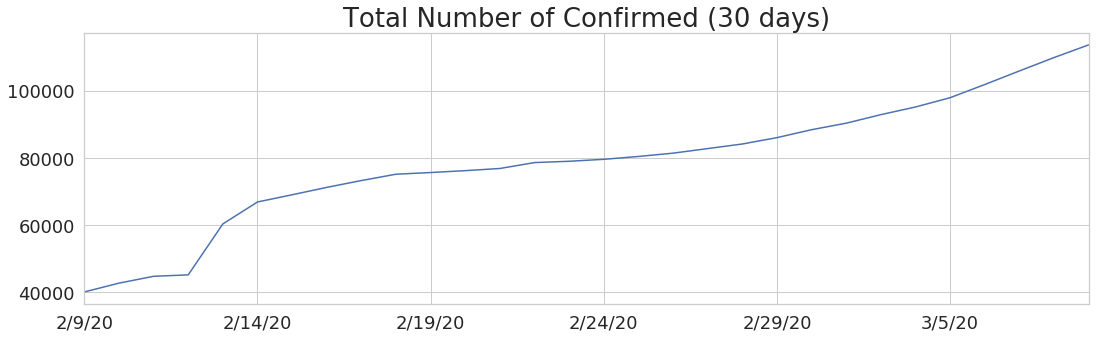

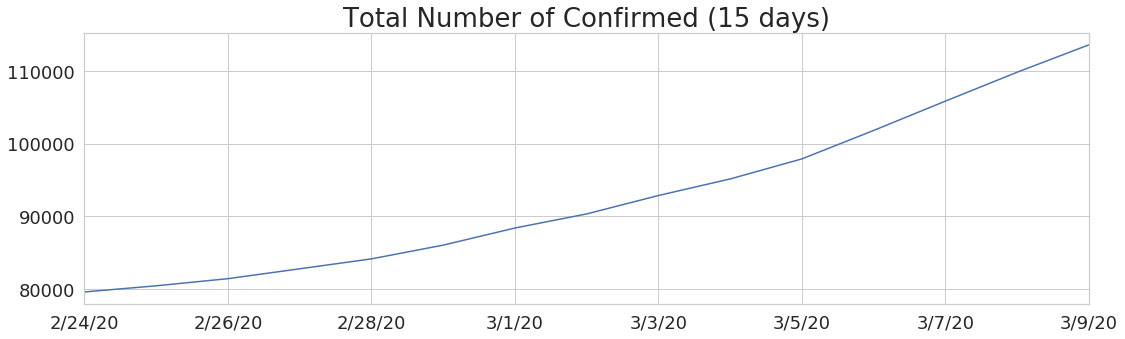

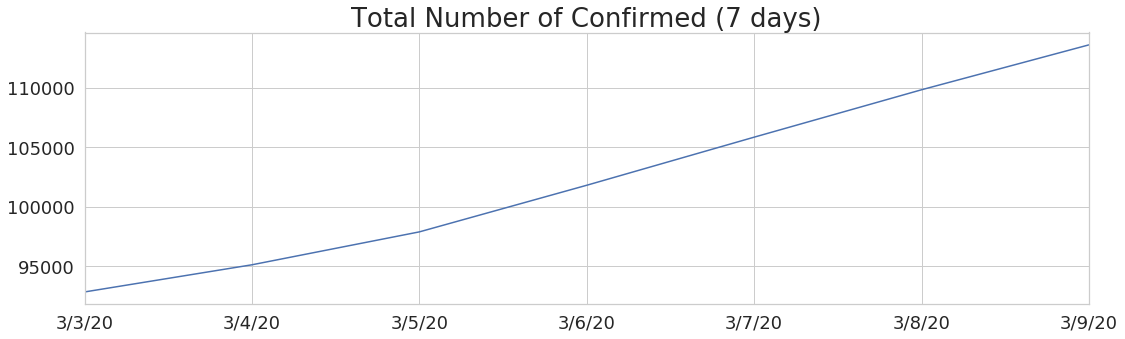

In [35]:
ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


df = time_series_covid_19_confirmed
title_key = " Confirmed "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

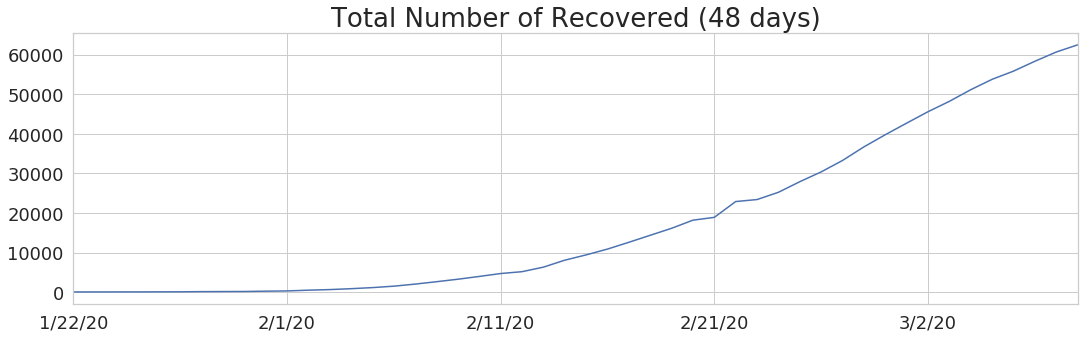

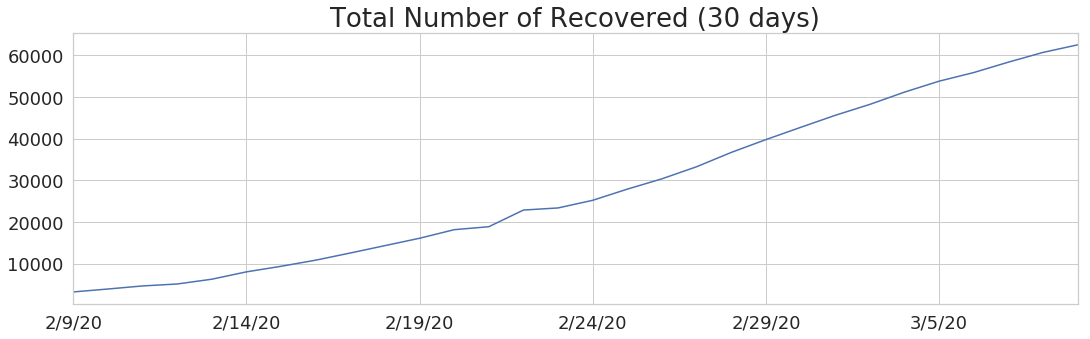

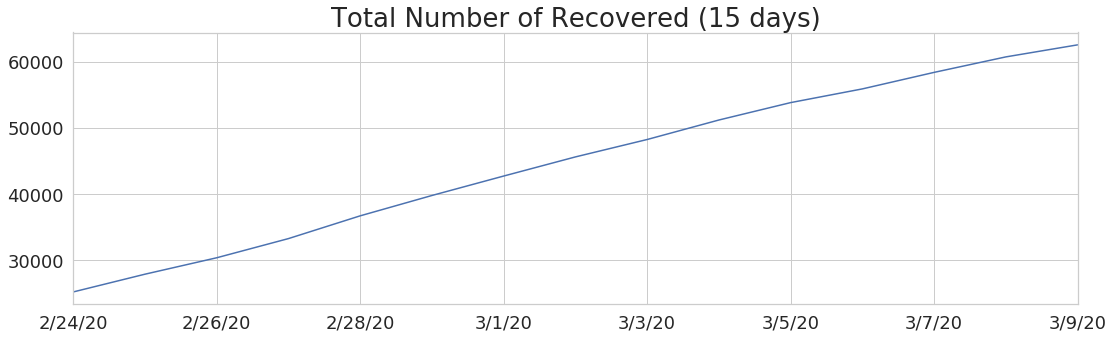

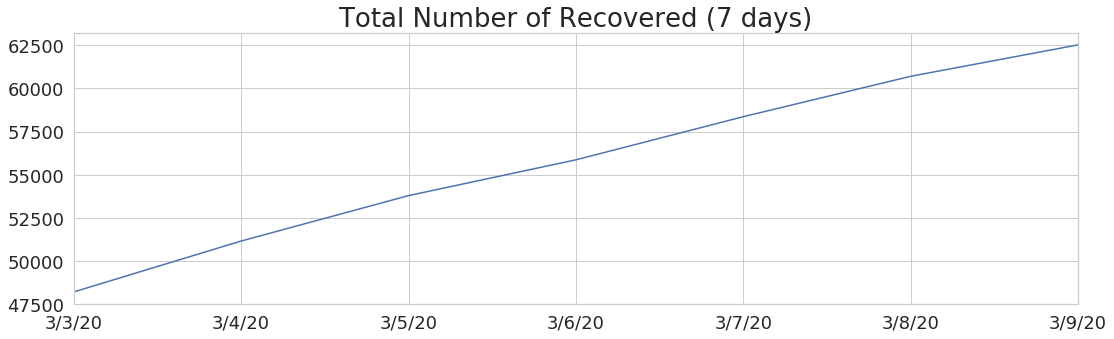

In [36]:
ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


df = time_series_covid_19_recovered
title_key = " Recovered "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

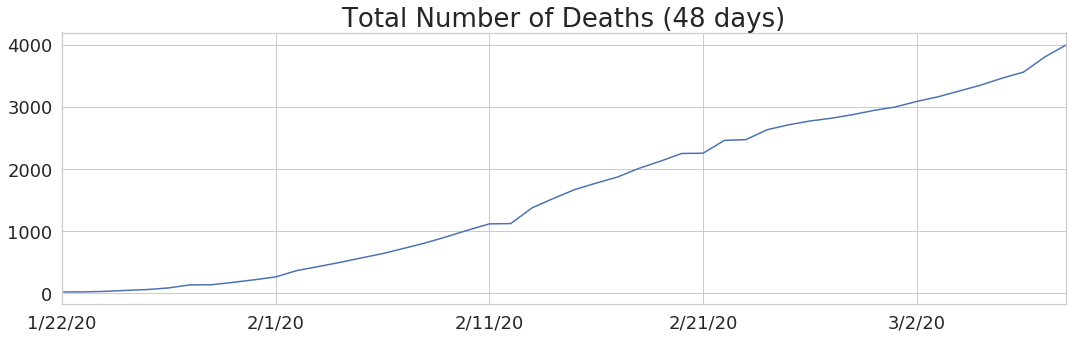

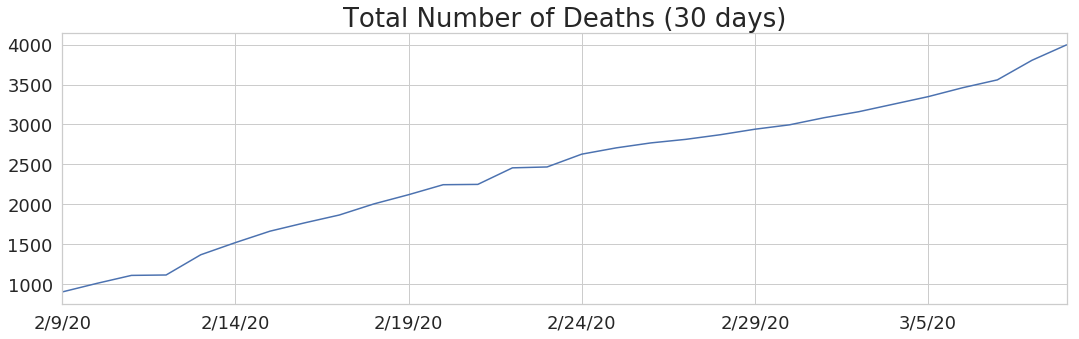

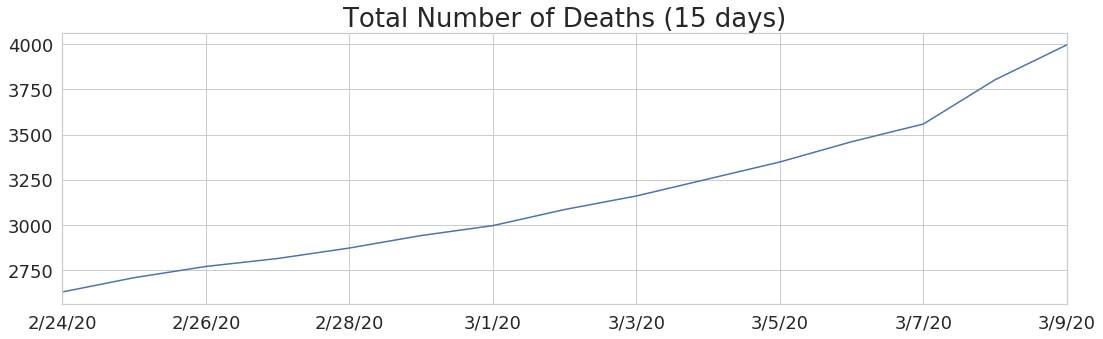

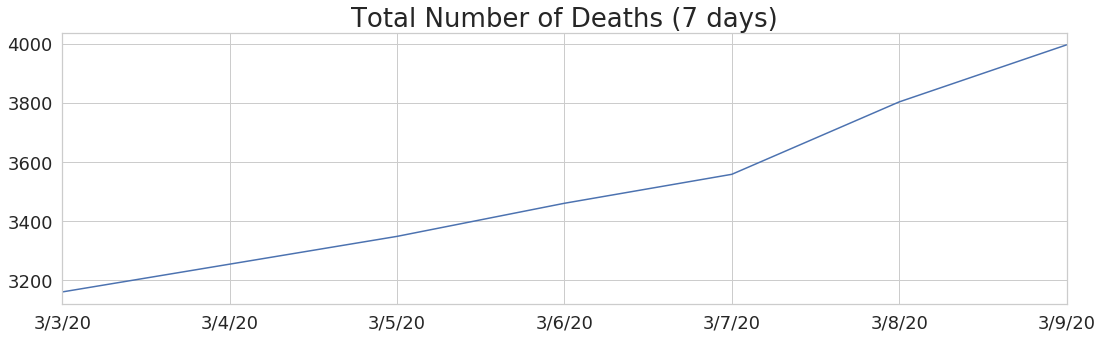

In [37]:
ticksize = 18
titlesize = ticksize + 8
labelsize = ticksize + 5

figsize = (18, 5)
params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)


df = time_series_covid_19_deaths
title_key = " Deaths "
title_text = "Total Number of" + title_key + "("


for count_days_now in count_days_vis:
    title = title_text + str(count_days_now) + " days)" 
    df[data_cols[-count_days_now:]].sum().plot(kind=count_days_vis[count_days_now])
    plt.title(title)
    plt.show()

In [38]:
# ticksize = 18
# titlesize = ticksize + 8
# labelsize = ticksize + 5

# figsize = (18, 5)
# params = {'figure.figsize' : figsize,
#           'axes.labelsize' : labelsize,
#           'axes.titlesize' : titlesize,
#           'xtick.labelsize': ticksize,
#           'ytick.labelsize': ticksize}

# # plt.xticks(rotation=90)

# i = 0
# for index, row in country_stat_pd.iterrows():
#     if row["Confirm"]>10 or row["Recovered"]>1 or row["Death"]>1:
#         row.plot(kind ="bar")
#         plt.title(index)
#         plt.show()
#         i+=1

In [39]:
# from mpl_toolkits.basemap import Basemap

# plt.figure(figsize=(8, 8))
# m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
# m.bluemarble(scale=0.5);


In [40]:
# # cities = pd.read_csv('data/california_cities.csv')

# df = time_series_covid_19_confirmed
# # Extract the data we're interested in
# lat = df['Lat'].values
# lon = df['Long'].values
# confirm_last = df[last_day].values
# # area = cities['area_total_km2'].values

In [41]:
# # 1. Draw the map background
# fig = plt.figure(figsize=(8, 8))
# m = Basemap(projection='lcc', resolution='h', 
#             lat_0=37.5, lon_0=-119,
#             width=1E6, height=1.2E6)
# m.shadedrelief()
# m.drawcoastlines(color='gray')
# m.drawcountries(color='gray')
# m.drawstates(color='gray')

# # 2. scatter city data, with color reflecting population
# # and size reflecting area
# m.scatter(lon, lat, latlon=True,
#           c=np.log10(population),
#           cmap='Reds', alpha=0.5)

# # 3. create colorbar and legend
# plt.colorbar(label=r'$\log_{10}({\rm population})$')
# plt.clim(3, 7)

# # make legend with dummy points
# for a in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.5, s=a,
#                 label=str(a) + ' km$^2$')
# plt.legend(scatterpoints=1, frameon=False,
#            labelspacing=1, loc='lower left');